In [1]:
import spacy
from pathlib import Path
from collections import Counter

In [2]:
current_path = Path(".").resolve()
project_path = current_path.parent

In [3]:
nlp = spacy.load("en_core_web_md")

## Generate the emoji vocabulary

In [4]:
vocab = set()

In [5]:
with open(project_path / "emoji2vec" / "data" / "raw_training_data" / "emoji_joined.txt", "r", encoding="utf-8") as f:
    for line in f:
        e = line.strip().split("\t")[1]
        # counter.update(e)
        vocab.add(e)

In [6]:
vocab = list(vocab)
vocab = ["PAD"] + vocab

In [7]:
len(vocab)

1662

In [8]:
vocab[:10]

['PAD', '🏊', '💃🏻', '🅱️', '⬛', '☔️', '📱', '🇯🇲', '👶🏿', '3⃣️']

In [9]:
with open(current_path / "data"/ "vocab.txt", "w", encoding="utf-8") as f:
    for e in vocab:
        f.write(e + "\n")

## Load the Word2Vec model and take a look

In [10]:
import gensim
import numpy as np

In [34]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format(current_path / '..' / 'GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
word2vec.most_similar("plane")

## Try to load the emoji2vec dataset using Pandas

In [13]:
import pandas as pd


def load_emoji2vec_dataset(fpath):
    """
    Load the dataset in emoji2vec using pandas DataFrame
    """
    descs = []
    emojis = []
    labels = []
    with open(fpath, "r", encoding="utf-8") as f:
        for line in f:
            d, e, l = line.strip().split("\t")
            descs.append(d)
            emojis.append(e)
            if l == "True":
                labels.append(1)
            else:
                labels.append(0)
    
    return pd.DataFrame({"description": descs, "emoji": emojis, "label": labels})
    

In [14]:
train_df = load_emoji2vec_dataset(project_path / "emoji2vec" / "data" / "training" / "train.txt")

In [15]:
train_df

,description,emoji,label
0,regional indicator symbol letters sk,🇸🇰,1
1,necktie,👔,1
2,weather,🌀,1
3,throne,🚾,1
4,scary,👹,1
...,...,...,...
5583,phone call,📲,1
5584,regional indicator symbol letters kw,🇰🇼,1
5585,cake,🍰,1
5586,regional indicator symbol letters lv,🇱🇻,1


In [16]:
dev_df = load_emoji2vec_dataset(project_path / "emoji2vec" / "data" / "training" / "dev.txt")
test_df = load_emoji2vec_dataset(project_path / "emoji2vec" / "data" / "training" / "test.txt")

In [26]:
print("Number of samples for each split:")
print(len(train_df), len(dev_df), len(test_df))

Number of samples for each split:
5588 500 500


In [28]:
print("Number of positive/negative samples:")
print("Train: ", len(train_df[train_df["label"] == 1]), len(train_df[train_df["label"] == 0]))
print("Dev: ", len(dev_df[dev_df["label"] == 1]), len(dev_df[dev_df["label"] == 0]))
print("Test: ", len(test_df[test_df["label"] == 1]), len(test_df[test_df["label"] == 0]))

Number of positive/negative samples:
Train:  5588 0
Dev:  250 250
Test:  250 250


There's no negative samples in the **training set**, thus we need to randomly draw negative samples with the same number of positive smaples.

In [30]:
neg_df = load_emoji2vec_dataset(project_path / "emoji2vec" / "data" / "raw_training_data" / "shuf_neg_samples.txt")
neg_df

,description,emoji,label
0,buzz,🚣🏻,0
1,squared new,👴,0
2,sake bottle and cup,🔲,0
3,flag for singapore,🍚,0
4,heat,🕴,0
...,...,...,...
149151,white girl,🐖,0
149152,heavy black heart,🍁,0
149153,flag for qatar,🚢,0
149154,gala apple,🙎,0


Plot the length of descriptions in the training set

In [18]:
train_desc_lens = [len(nlp(x)) for x in train_df["description"]]

(array([4.41e+03, 5.58e+02, 2.24e+02, 2.97e+02, 4.80e+01, 3.40e+01,
        5.00e+00, 4.00e+00, 3.00e+00, 5.00e+00]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

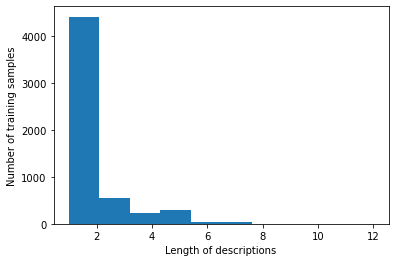

In [19]:
from matplotlib import pyplot as plt

plt.xlabel('Length of descriptions')
plt.ylabel('Number of training samples')
plt.hist(x=train_desc_lens)

Try out a transform function to transform a sentence into list of word vectors.

In [20]:
from spacy.lang.en.stop_words import STOP_WORDS
import string

def transform(sentence: str, max_len, nlp, word2vec):
    """
    Transform a sentence into word vectors. The setence is tokenized into words using spacy, then
    the vector of each word is retrieved using the word2vec model.
    
    Args:
        sentence:
            The sentence to transform.
        max_len:
            The maximum length for each sentence.
        nlp:
            The SpaCy model.
        word2vec:
            The gensim word2vec model.
        
    """
    vec_dim = word2vec["hello"].shape[0]
    doc = nlp(sentence)
    vectors = []
    for token in doc:
        if len(vectors) == max_len:
            break
        # If the token isn't in the word2vec model
        if token.text not in word2vec.wv:
            continue
        vectors.append(word2vec[token.text])

    # If the length is < max_len, add padding
    if len(vectors) < max_len:
        num_padding = max_len - len(vectors)
        for i in range(num_padding):
            vectors.append(np.zeros(shape=[1, vec_dim]))
    # If the length is too long, we truncate the sentence
    elif len(vectors) > max_len:
        vectors = vectors[:max_len]
    
    assert len(vectors) == max_len

    return np.vstack(vectors)

In [21]:
transform("I have a dream", 5, nlp, word2vec).shape

D:\anaconda3\envs\wga\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


(5, 300)